# OpenAI Gym


In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

import gymnasium as gym

from extravaganza.dynamical_systems import Gym

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpc5tm9g_u
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpc5tm9g_u/_remote_module_non_scriptable.py


## System
Here, we work with games in the OpenAI gym, such as `MountainCarContinuous-v0`, in which we supply a value in `[-1, 1]` as a control to push a car left or right up a mountain. The tricky thing about this environment is that you first have to push the car up the left to gain momentum, even though the goal is on the right.

Another good environment is the `CartPole` enviroment (left and right bumps on a cart to keep an inverted pendulum upright), whose continuous analog is also displayed below.

We make use of **only the reward signal or cost function** to train, not using any state observation.

MountainCar | CartPole
- | - 
![mountaincar.gif](https://www.gymlibrary.dev/_images/mountain_car.gif) | ![cart_pole.gif](https://www.gymlibrary.dev/_images/cart_pole.gif)

## Hyperparameters

In [19]:
name = 'gymtesty'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 16000  # total timesteps
    T0 = 10000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # when to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 1
    ds = 4
    env_name = 'CartPoleContinuous-v1'  
    # env_name = 'MountainCarContinuous-v0'
    make_system = lambda : Gym(env_name=env_name, repeat=1, max_episode_len=2000, seed=SYSTEM_SEED)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------
    
    dl = 1
    
#     observable = TimeDelayedObservation(hh = 3, state_dim=ds, control_dim=du, 
#                                         use_states=False, use_controls=True, 
#                                         use_costs=True, use_cost_diffs=False,
#                                         use_time=False)

#     observable = PartialObservation(obs_dim = 3, state_dim=ds, seed=SYSTEM_SEED)
    observable = FullObservation(state_dim=ds)
    
#     if env_name == 'CartPoleContinuous-v1':
#         assert ds == 4 and du == 1
#         def cartpole_obs_func(traj: Trajectory):
#             obs = traj.x[-1]
#             obs.at[0].set(obs[0] / 10)
#             obs.at[1].set(obs[1] / 100)
#             obs.at[3].set(obs[3] / 100)
#             return obs
#         observable = Observable(obs_func=cartpole_obs_func, obs_dim=ds)
        
    do = observable.obs_dim
    
    exploration_args = {'scales': 0.3, 'avg_len': 3,}
    sysid_args = {
        'obs_dim': do,
        'control_dim': du,

        'exploration_args': {'random 1.0': exploration_args,
#                              'impulse 0.4': exploration_args,
                            },

        'method': 'nn',
        'AB_method': 'learned',
        'deterministic': True,
        'isometric': False,

        'sigma': 0,
        'depth': 8,
        'num_iters': 16000,
        'batch_size': 256,
        'lifter_lr': 0.001,
        'hh': 5,

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 4  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.000, betas=(0.9, 0.999))
#     m0_update_rescaler = lambda : FIXED_RESCALE(alpha=-0.01, beta=0.999)
    k_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.4, beta=0.6)

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0, 0.005, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'seed': CONTROLLER_SEED
    }
    
    make_controllers = {
#         'Lifted LQR': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=LQR(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted HINF': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=HINF(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
        'Lifted GPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=GPC(sysid.A, sysid.B, decay=False, lr_scale=0.01, H=10), lifter=sysid),
                                          sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted EvanBPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=EvanBPC(sysid.A, sysid.B, **nonlinear_bpc_args), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0)
    }

    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [20]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Lifted GPC
INFO: (EXPLORER) generating exploration control sequences using ['random'] w.p. [1.]
INFO: (LIFTER): using "learned" method to get the AB matrices during each training step
 17%|████████████████████████▋                                                                                                                       | 2745/16000 [00:01<00:08, 1642.20it/s, control=0.15, cost=0.000544]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 62%|███████████████████████████████

INFO: 		l2 linearization 2: 	0.00013146093707291584
INFO: 		l2 linearization 3: 	0.0002132346060875534
INFO: 		l2 linearization 4: 	0.00031634663467229986
INFO: 		nontrivial: 	0.014413796300068497
INFO: 		simplification: 	0.001771064867862151
INFO: 		simplification 0: 	0.0019431697132313275
INFO: 		simplification 1: 	0.0019133049570882576
INFO: 		simplification 2: 	0.0019048741499136667
INFO: 		simplification 3: 	0.0019213020718234475
INFO: 		simplification 4: 	0.0019524580649340352
INFO: mean loss for iters 14399 - 15999:
INFO: 		guess the control: 	0.00044127805844254906
INFO: 		l2 linearization 0: 	3.071958498452432e-05
INFO: 		l2 linearization 1: 	7.236945330532763e-05
INFO: 		l2 linearization 2: 	0.00013560506142425765
INFO: 		l2 linearization 3: 	0.0002200589246922391
INFO: 		l2 linearization 4: 	0.0003260412079566777
INFO: 		nontrivial: 	0.014391710404888727
INFO: 		simplification: 	0.0017688813900895183
INFO: 		simplification 0: 	0.001938413031421078
INFO: 		simplification 1: 	

regression :
||A||_op = 0.8892420086457521
||B||_F = 0.03043463033680538
||A-BK||_op = 0.8853859215705611
eig(A) = [0.88924201]
svd(B) = [0.03043463]

moments :
||A||_op = 0.9243128837056289
||B||_F = 0.0026893594892629796
||A-BK||_op = 0.9242669986704312
eig(A) = [0.92431288]
svd(B) = [0.00268936]

learned (ret) :
||A||_op = 1.0860679149627686
||B||_F = 0.03353103622794151
||A-BK||_op = 0.9152075572041393
eig(A) = [1.0860679]
svd(B) = [0.03353104]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16000/16000 [01:01<00:00, 259.49it/s, control=-.00374, cost=0.000111]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 61.673158624907956 seconds


In [4]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [12]:
def plot_gym(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 2
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'true states', label=method, plot_idx=2)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        
#         stats.plot(ax[2, 0], 'states', label=method, plot_norm=True)  # norm of the "state"
        for j in range(1):
            stats.plot(ax[2, 0], 'states', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(ax[2, 1], 'linearization', label='linearization')  # various nn losses
        stats.plot(ax[2, 1], 'simplification', label='simplification')
        stats.plot(ax[2, 1], 'reconstruction', label='reconstruction')
        stats.plot(ax[2, 1], 'controllability', label='controllability')
            
#         i_ax = ax[n + i // 2, i % 2]
        i_ax = ax[2, 1]
        for j in range(1):
            stats.plot(ax[0, 1], 'disturbances', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('true states'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 3)
    _ax = ax[2, 0]; _ax.set_title('reconstructed states'); _ax.legend()
    pass

### Plot
note: for cartpole we want controls to be in same direction as pole angle. if we play negative control, angle goes more positive. so, when met with positive angle, we should play positive control.

<Figure size 640x480 with 0 Axes>

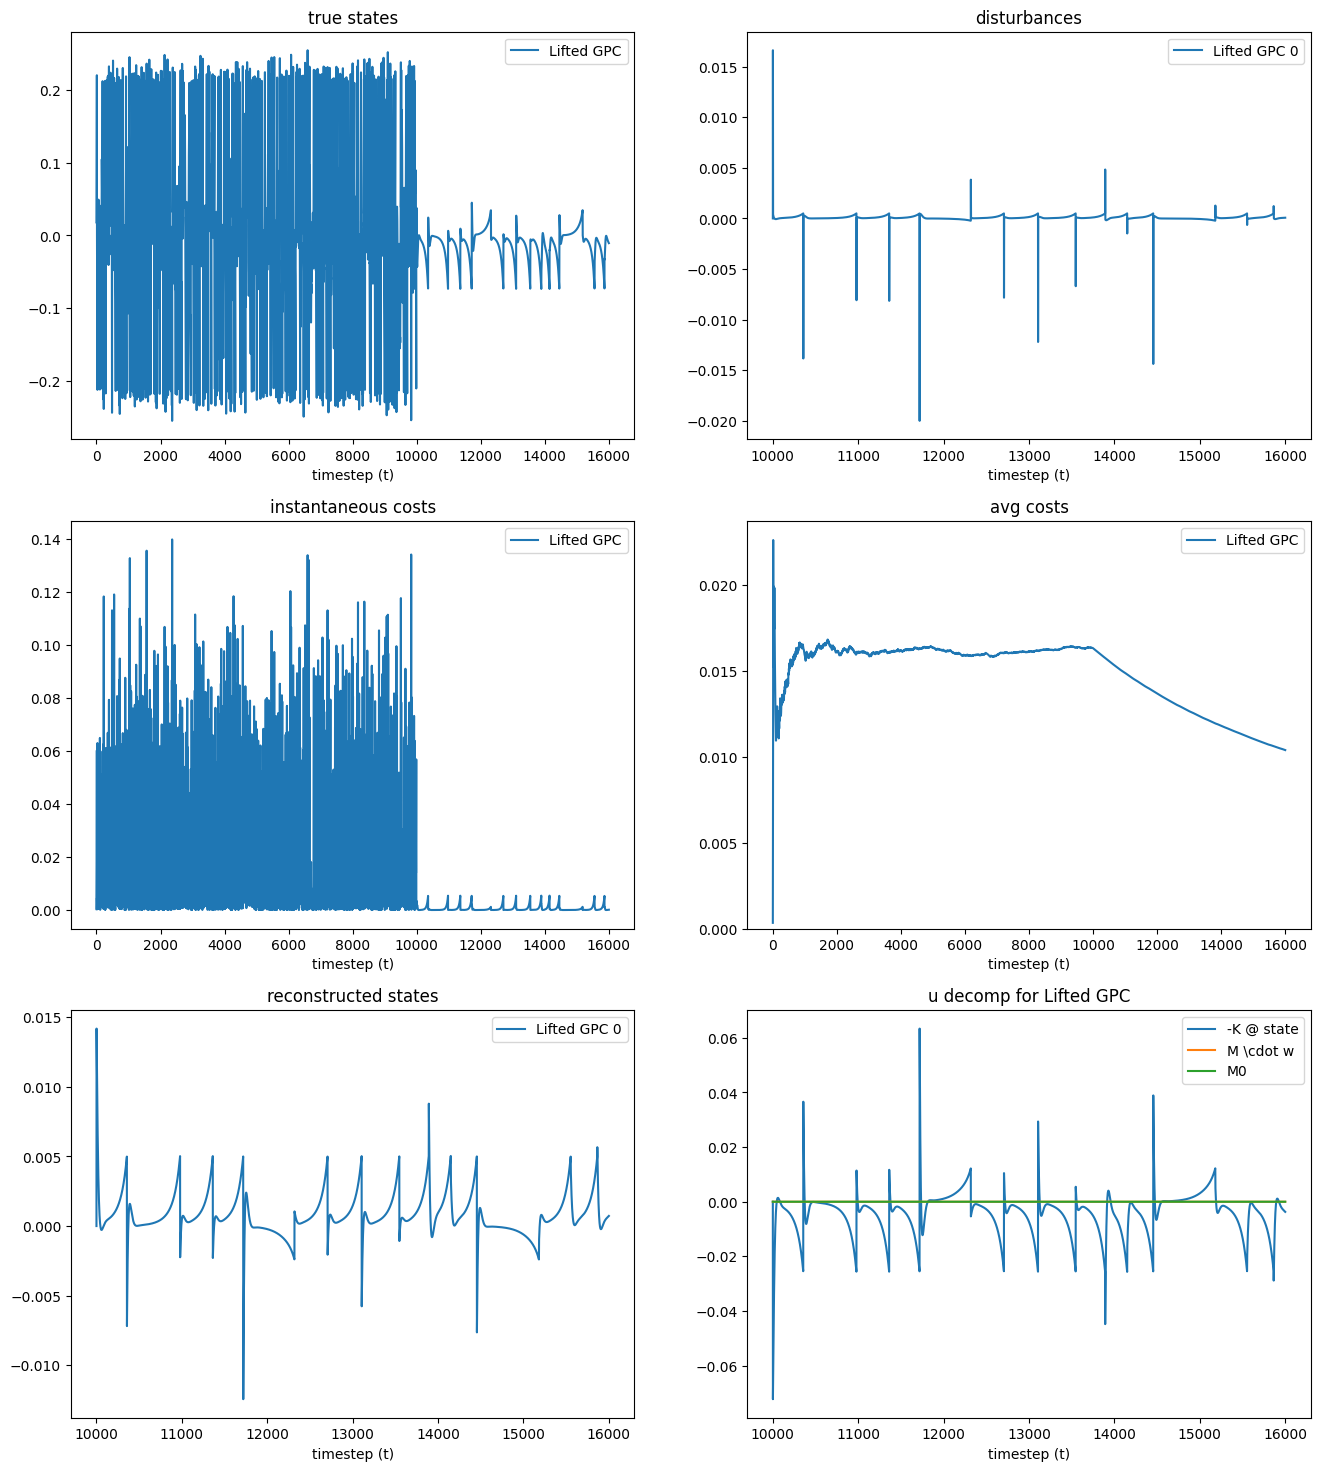

In [21]:
plot_gym(experiment)

### a